In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls

import matplotlib 
matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)


In [67]:
data = pd.read_csv('kepler1513_ttvs_final.csv', sep=',')
times_input = data['times'].values
times_err_low_input = data['times_low_err'].values
times_err_high_input = data['times_high_err'].values
times_err_input = np.mean([times_err_low, times_err_low], axis=0)
epochs_input = data['epochs'].values+1




times_err_input

array([0.00038345, 0.00042516, 0.00046407, 0.00040265, 0.00043194,
       0.00036084, 0.00041575, 0.00037334, 0.00336501, 0.00159417])

In [68]:
# p = 160.88409 + 7e-05 - 7e-05 from transit model
# t0 = 277.50639 + 0.00031 - 0.00031 from transit model

period = 160.88409 
t0 = 277.50639 

linear_ephemeris_times = []
for epoch in epochs:
    linear_ephemeris_times.append(t0+period*(epoch-1))
    
    
linear_ephemeris_times = np.array(linear_ephemeris_times)
print(linear_ephemeris_times)

[ 277.50639  438.39048  760.15866  921.04275 1081.92684 1242.81093
 1403.69502 1564.57911 4943.145   5264.91318]


In [69]:
Pmin = 2
Pmax = 100
fmin = 1/Pmax
fmax = 1/Pmin

fgrid = np.arange(fmin, fmax, 0.1*fmin)
Pgrid = np.sort(1/fgrid)



In [70]:
def get_times_ttv_model(epochs, T0, P, P_ttv, alpha_ttv, beta_ttv): 
    return T0 + P * epochs + alpha_ttv * np.sin((2 * np.pi * epochs / P_ttv)) + beta_ttv * np.cos((2 * np.pi * epochs / P_ttv))

def solve_ttv_model(epochs, times, times_err, P_ttv):
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs,
        np.sin(2 * np.pi * epochs / P_ttv),
        np.cos(2 * np.pi * epochs / P_ttv)
    ])
    

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times
    

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit, alpha_ttv_fit, beta_ttv_fit = parameters

    return T0_fit, P_fit, P_ttv, alpha_ttv_fit, beta_ttv_fit

In [71]:
def get_times_null_model(epochs, T0, P): 
    return T0 + P*epochs


def solve_null_model(epochs, times, times_err):
    # Constructing the design matrix A
    A = np.column_stack([
        np.ones_like(epochs),
        epochs
    ])

    # Constructing the weight matrix W using times_err
    W = np.diag(1.0 / times_err**2.)

    # Constructing the observed times vector y
    y = times

    # Calculating the parameters using np.linalg.solve
    parameters = np.linalg.solve(A.T @ W @ A, A.T @ W @ y)

    T0_fit, P_fit = parameters

    return T0_fit, P_fit

In [72]:
def get_chisq(observed_data, predicted_data, uncertainties):
    """
    Calculate the chi-square statistic for model evaluation.

    Parameters:
        observed_data (numpy array): Array of observed data points.
        predicted_data (numpy array): Array of model-predicted data points.
        uncertainties (numpy array): Array of uncertainties/standard deviations of the observed data.

    Returns:
        float: The chi-square statistic.
    """
    if len(observed_data) != len(predicted_data) or len(observed_data) != len(uncertainties):
        raise ValueError("All input arrays must have the same length.")

    squared_residuals = ((observed_data - predicted_data) ** 2. / (uncertainties ** 2.) )
    chi_square = np.sum(squared_residuals)

    return chi_square


def get_log_likelihood(chi_square):
    """
    Calculate the log-likelihood from the chi-square value.

    Parameters:
        chi_square (float): The chi-square value of the model.
        num_data_points (int): Number of data points (sample size).

    Returns:
        float: The log-likelihood.
    """
    log_likelihood = -0.5 * chi_square
    return log_likelihood

def get_BIC(num_params, num_data_points, log_likelihood):
    """
    Calculate the Bayesian Information Criterion (BIC).

    Parameters:
        num_params (int): Number of parameters in the model.
        num_data_points (int): Number of data points (sample size).
        log_likelihood (float): Log-likelihood of the model.

    Returns:
        float: The BIC value.
    """
    BIC = num_params * np.log(num_data_points) - 2 * log_likelihood
    return BIC


In [73]:
def get_times_model_2waves(epochs, T0, P, P1_ttv, alpha1_ttv, beta1_ttv, alpha2_ttv, beta2_ttv): 
    linear = P*epochs
    wave1 = alpha1_ttv*np.sin((2*np.pi*epochs/ P1_ttv)) +  beta1_ttv*np.cos((2*np.pi*epochs/ P1_ttv))
    wave2 = alpha2_ttv*np.sin((2*np.pi*epochs/ P2_ttv)) +  beta2_ttv*np.cos((2*np.pi*epochs/ P2_ttv))
    
    return T0 + linear + wave1 + wave2
    

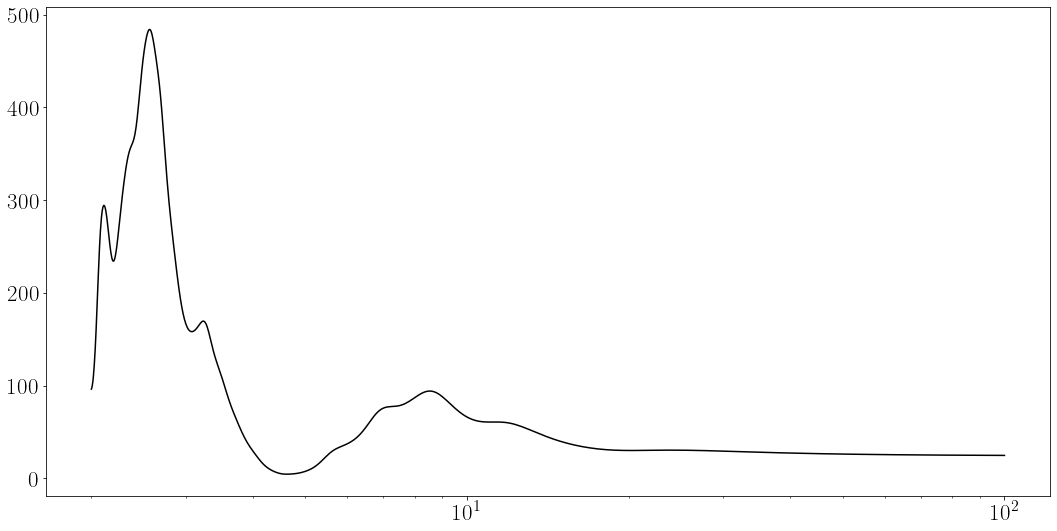

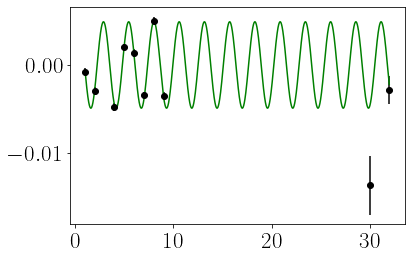

LS results
(116.6220607148859, 160.8843392008956, 2.5706940874036013, 0.003388877601185255, 0.0035852424586576095)
0.004933401958403186


In [80]:
epochs, times, times_err = epochs_input, times_input, times_err_input





null_model  = solve_null_model(epochs, times, times_err)
times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)




#plt.errorbar(epochs, times-times_null_model, yerr=times_err, ls='', marker='o', color='k')
#plt.plot(epochs, times_null_model-times_null_model)



delta_chisq_grid1 = []
ttv_chisq_grid1 = []
for P_ttv in Pgrid:
    a_model  = solve_ttv_model(epochs, times, times_err, P_ttv)
    times_a_model = get_times_ttv_model(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - a_chisq
    if delta_chisq < 0:
        delta_chisq = 0.
    delta_chisq_grid1.append(delta_chisq)
    ttv_chisq_grid1.append(a_chisq)


plt.figure(figsize=[18,9])
plt.plot(Pgrid, delta_chisq_grid1, 'k')
# Set the x-axis to be in log scale
plt.xscale('log')
plt.show()


#find max chisq ttv
max_delta_chisq = 0
min_ttv_chisq = 0
best_P_ttv = None
for ii in range(0, len(delta_chisq_grid1)):
    delta_chisq = delta_chisq_grid1[ii]
    ttv_chisq = ttv_chisq_grid1[ii]
    period = Pgrid[ii]
    if delta_chisq > max_delta_chisq:
        max_delta_chisq = delta_chisq
        min_ttv_chisq = ttv_chisq
        best_P_ttv = period





#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
P_ttv = best_P_ttv
max_model  = solve_ttv_model(epochs, times, times_err, P_ttv) 
best_alpha_ttv, best_beta_ttv = max_model[2], max_model[3]
#times_max_model = get_times_model(epochs, *max_model)


ttvs_max_model = get_times_ttv_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])


plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_model, 'g')

plt.show()


BIC_ttv = get_BIC(min_ttv_chisq, len(times), 4)
BIC_ttv_linear = get_BIC(null_chisq, len(times), 2)

delta_BIC = BIC_ttv_linear-BIC_ttv

amplitude_ttv = np.sqrt(best_alpha_ttv**2. + best_alpha_ttv**2.)

print('LS results')
print(max_model)
print(np.sqrt(max_model[3]**2. + max_model[4]**2.))


#if delta_BIC > 10:
#    kois.append(koi)


#    plt.show()

## now run 2 sin wave LS

8.781115879828327
[ 1.16622738e+02  1.60884175e+02  2.59707310e+00  2.83814479e-03
  3.81578671e-03 -9.24634208e-04  4.65650916e-04]


/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


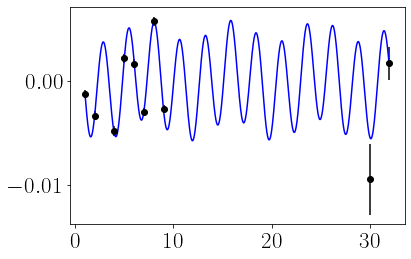

In [81]:
from scipy import optimize

null_model,_  = optimize.curve_fit(get_times_null_model, epochs, times, sigma=times_err, absolute_sigma = True)
times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)


delta_chisq_grid2 = []
ttv_chisq_grid2 = []
p_guess = np.append(max_model, [0,0])
for P2_ttv in Pgrid:
    #P2_ttv = max_fast_period
    a_model,_  = optimize.curve_fit(get_times_model_2waves, epochs, times, 
                                    sigma=times_err, absolute_sigma = True,p0 = p_guess)
    times_a_model = get_times_model_2waves(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - a_chisq - max_delta_chisq
    if delta_chisq < 0:
        delta_chisq = 0.
    delta_chisq_grid2.append(delta_chisq)
    ttv_chisq_grid2.append(a_chisq)

    
    
#find max chisq ttv
max_delta_chisq = 0
min_ttv_chisq = 0
best_P_ttv = None
for ii in range(0, len(delta_chisq_grid2)):
    delta_chisq = delta_chisq_grid2[ii]
    ttv_chisq = ttv_chisq_grid2[ii]
    period = Pgrid[ii]
    if chisq > max_slow_chisq:
        max_delta_chisq = delta_chisq
        min_ttv_chisq = ttv_chisq
        best_P_ttv = period
        
        
#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
P2_ttv = max_slow_period
print(P2_ttv)
max_model,_  = optimize.curve_fit(get_times_model_2waves, epochs, times, 
                                  sigma=times_err, absolute_sigma = True, p0=p_guess)
print(max_model)
ttvs_max_model = get_times_model_2waves(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])

plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_model, 'b')
    
    

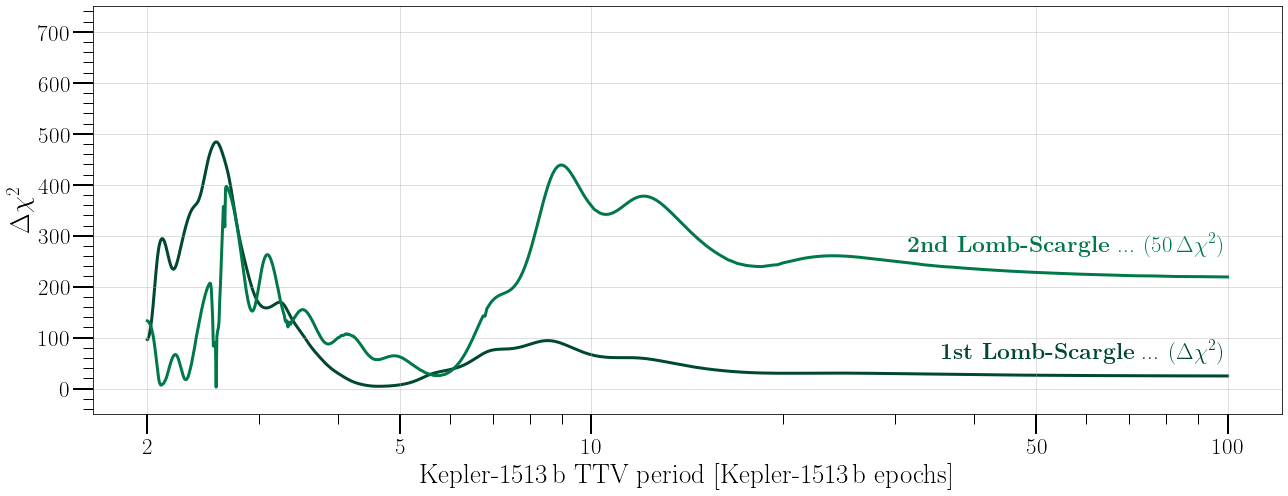

In [83]:
fig, ax = plt.subplots(1, figsize=[18, 7])


ax.plot(Pgrid, 50*np.array(delta_chisq_grid2), color="#007848", ls='-', lw=3)
ax.plot(Pgrid, delta_chisq_grid1, color="#004830", lw=3, ls='-', zorder=-100)


ax.set_xlabel(r'Kepler-1513\,b TTV period [Kepler-1513\,b epochs]', fontsize=27)
ax.set_ylabel(r'$\Delta \chi ^2$', fontsize=27)

ax.set_xscale('log')


ax.grid(visible=True, alpha=0.5)
ax.set_xticks([2, 5, 10, 50, 100])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax.text(99, 270, r'\textbf{2nd Lomb-Scargle} ... (50\,$\Delta \chi^2$)', color = '#007848', fontsize=23, horizontalalignment='right')
ax.text(99, 60, r'\textbf{1st Lomb-Scargle} ... ($\Delta \chi^2$)', color = '#004830', fontsize=23, horizontalalignment='right')

#ax.text(6, 530, r'\textbf{Lomb-Scargle Periodogram}', color = 'k', fontsize=27, horizontalalignment='center')

# We change the length of ticks 
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
ax.minorticks_on()

plt.ylim(-50, 750)



plt.tight_layout()
#plt.savefig('periodogram_2ttvs.pdf')

plt.show()
